In [1]:
import numpy as np
import pandas as pd

df = pd.read_parquet('Metal_all_20180116.snappy.parquet')
# print ('***** Data Types *****' + '\n' + str(df.dtypes) + '\n\n' + 
#        '***** Unique Ligands *****' + '\n' + str(df.ligandId.unique()))

# Extract zinc-binded, single-chained protein sequences
df_zn = df.loc[df['ligandId'] == 'ZN']
df_zn_single = df_zn.loc[df_zn['interactingChains'] == 1]
seqs = np.array(df_zn_single.sequence)
target = np.array(df_zn_single.fingerprint)

del df,df_zn,df_zn_single

In [2]:
# Remove seqs containing 'U' and 'X'
rows_to_delete = []
for i in range(seqs.shape[0]):
    if 'X' in seqs[i] or 'U' in seqs[i]:
#         print('Removing...' + str(i))
        rows_to_delete.append(i)        
        
seqs = np.delete(seqs, rows_to_delete, 0)
target = np.delete(target, rows_to_delete)
print ("Sequence length is " + str(seqs.shape[0]))

Sequence length is 22784


In [36]:
symbol_counts = {}
for i in range(seqs.shape[0]):
    for j in range(target[i].shape[0]):
        if seqs[i][target[i][j]] not in symbol_counts.keys():
            symbol_counts[seqs[i][target[i][j]]] = 1
        else:
            symbol_counts[seqs[i][target[i][j]]] += 1

print ('Symbol Dict: ', symbol_counts)
print ('Total: ', sum(symbol_counts.values()))
print ('[C,H / Total]: ', (symbol_counts['C'] + symbol_counts['H']) / sum(symbol_counts.values()))

Symbol Dict:  {'D': 9266, 'S': 185, 'H': 29210, 'C': 37542, 'E': 4625, 'K': 831, 'G': 47, 'Y': 75, 'N': 217, 'Q': 48, 'A': 31, 'W': 44, 'T': 147, 'R': 32, 'M': 21, 'F': 14, 'I': 18, 'V': 11, 'L': 24, 'P': 2}
Total:  82390
[C,H / Total]:  0.8101954120645709


#### Proportion of C,H binding sites 

All seqs: 0.37

Zn-binded, single-chain: 0.81

In [3]:
# Filepaths
dict_path = "./dictionaries/"
model_path = "./models/"
hist_path = "./histories/"
fig_path = "./figs/"

### Input - ProtVec Embedding

In [4]:
# Load
seqs_dict = {}
with open(dict_path + "seq_n_gram_to_vec_dict_w_UX", 'r') as fp:
        seqs_dict = json.load(fp)

### Input - Onehot Encoding

In [4]:
onehot_keys = []
for i in range(seqs.shape[0]):
    for j in range(len(seqs[i])):
        if seqs[i][j] not in onehot_keys:
            onehot_keys.append(seqs[i][j])
# import operator
# print (sorted(seqs_dict_onehot.items(), key=operator.itemgetter(1)))
onehot_keys = np.array(onehot_keys).reshape(-1)
np.random.shuffle(onehot_keys)

seqs_dict_onehot = {}
onehot_matrix = np.eye(onehot_keys.shape[0])
for i in range(onehot_keys.shape[0]):
    seqs_dict_onehot[onehot_keys[i]] = onehot_matrix[i].tolist()

In [5]:
seqs_dict_onehot = {}
with open(dict_path + "seqs_dict_onehot", 'r') as fp:
        seqs_dict_onehot = json.load(fp)

In [6]:
for i in seqs_dict_onehot.keys():
    print(i, [int(x) for x in seqs_dict_onehot[i]])

G [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
K [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Y [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
F [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
V [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
S [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
P [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
H [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
M [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
N [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
D [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
C [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
L [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
T [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
W [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
I [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

### Construct feature vector

In [7]:
# Onehot encoding given a cutoff (Padded with 0s / Replicate partial sequence at the end)
def to_onehot(target_single, cutoff, seq_size, replicate=False):
    t = [0] * cutoff
    offset = cutoff - seq_size
    for i in target_single:
        t[i] = 1 
        if replicate and (i >= seq_size-offset) and (i < seq_size):
            t[offset+i] = 1
    return t

# Convert n-gram to vector given a dictionary
def to_vector(seqs_dict, seq, index, n_gram_size, dimension):
    if (index+n_gram_size) < len(seq):
        word = seq[index: index+n_gram_size]
        if '0' not in word:
            if word in seqs_dict.keys():
                return seqs_dict[word]
    return [0] * dimension

# Discard sequences longer than the cutoff and reconstruct datasets
def optimal_cutoff(seqs, target, cutoff, replicate=False):
    new_seqs = []
    new_target = []
    new_lengths = []
    for i, s, t in zip(range(seqs.shape[0]), seqs, target):
        if len(s) <= cutoff:
            if replicate:
                offset = cutoff-len(s)
                s = s + s[len(s)-offset : len(s)]
                new_seqs.append(s)
            else:
                new_seqs.append(s + (cutoff-len(s)) * '0')
            new_target.append(to_onehot(t,cutoff,len(s), replicate))
            new_lengths.append(len(s))
    return new_seqs, new_target, new_lengths

# Construct input tensor (Num_Samples x Cutoff X Dimension)
def construct_X(seqs_dict, seqs, cutoff, n_gram_size, dimension, sample_size, start_index):
    X = np.zeros((sample_size, cutoff, dimension))
    for i in range(sample_size):
        for j in range(cutoff):
            X[i][j] = np.array(to_vector(seqs_dict, seqs[start_index + i], j, n_gram_size, dimension))
    return X

# Get a pair of inputs for testing
def randomSample(X, Y):
    size = X.shape[0]
#     print (X.shape)
#     print (Y.shape)
    r = np.random.randint(size)
    retX = X[r].reshape((1, X.shape[1], X.shape[2]))
    retY = Y[r].reshape((1, Y.shape[1]))
    return (retX, retY)

# Paired randomization 
def shuffleXY(X, Y):
    C = list(zip(X, Y))
    random.shuffle(C)
    X_ret, Y_ret = zip(*C)
    return X_ret, Y_ret

In [8]:
# For hybrid model only
def random_sample_n_times(X, Y, size):
    X1, X2 = X
    n = X1.shape[0]
    _X1, _X2, _Y = [], [], []
    for i in range(size):
        r = np.random.randint(n)
        _X1.append(X1[r].tolist())
        _X2.append(X2[r].tolist())
        _Y.append(Y[r].tolist())
        
#     _X = [np.asarray(_X1), np.asarray(_X2)]
    _X = np.asarray(_X2)
    _Y = np.asarray(_Y)
    
    return _X, _Y 

In [9]:
lengths = np.zeros(len(seqs))
for i in range(len(seqs)):
    lengths[i] = len(seqs[i])

cutoff = int(np.mean(lengths) + 2 * np.std(lengths))
print ('Cutoff is ' + str(cutoff))
cv_ratio = 0.9

X, T, L = optimal_cutoff(seqs, target, cutoff)
X_train, X_val = X[:(int)(len(X) * cv_ratio)], X[(int)(len(X) * cv_ratio):]
T_train, T_val = T[:(int)(len(T) * cv_ratio)], T[(int)(len(T) * cv_ratio):]
print ('Training set size is ' + str(len(X_train)))
print ('Test set size is ' + str(len(X_val)))

Cutoff is 706
Training set size is 19577
Test set size is 2176


### Hybrid Model

In [10]:
seqs_dicts = [seqs_dict_onehot, seqs_dict]
dimensions = [20, 100]
lstm_size = 64
n_gram_size = 3

In [11]:
from keras.layers import LSTM, Dense,Dropout, TimeDistributed, Bidirectional, Input, Concatenate, Flatten
from keras.callbacks import Callback
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
# Visualization
from keras.utils import plot_model
# Custom layer
from keras import backend as K
from keras.engine.topology import Layer


import random

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Using TensorFlow backend.


In [12]:
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score

class custom_callback(Callback):
    def __init__(self,training_data,validation_data, sample_size, threshold_func):
        self.sample_size = sample_size
        self.threshold_func = threshold_func
        
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        
        self.roc_scores = []
        self.f1_scores = []
        self.precision_scores = []
        self.recall_scores = []
        

    def on_train_begin(self, logs={}):
        self.roc_scores = []
        self.f1_scores = []
        self.precision_scores = []
        self.recall_scores = []
        return
    
    def on_epoch_end(self, epoch, logs={}):
        x, y = random_sample_n_times(self.x, self.y, self.sample_size)
        x_val, y_val = random_sample_n_times(self.x_val, self.y_val, self.sample_size)

        y_pred = self.model.predict(x)
        y_pred_val = self.model.predict(x_val)

        roc = roc_auc_score(y.ravel(), y_pred.ravel())
        roc_val = roc_auc_score(y_val.ravel(), y_pred_val.ravel())
 
        y_pred = threshold_func(y_pred).astype(int)
        y_pred_val = threshold_func(y_pred_val).astype(int)
        
        f1 = f1_score(y.ravel(), y_pred.ravel())
        precision = precision_score(y.ravel(), y_pred.ravel())
        recall = recall_score(y.ravel(), y_pred.ravel())
        
        f1_val = f1_score(y_val.ravel(), y_pred_val.ravel())
        precision_val = precision_score(y_val.ravel(), y_pred_val.ravel())
        recall_val = recall_score(y_val.ravel(), y_pred_val.ravel())
        print ('F1', round(f1_val * 100,3), 'Pcsn', round(precision_val * 100,3), 'Rcl', round(recall_val * 100,3))
#         print (roc_val, f1_val, precision_val, recall_val)
        self.roc_scores.append((round(roc,4), round(roc_val,4)))
        self.f1_scores.append((round(f1,4), round(f1_val,4)))
        self.precision_scores.append((round(precision,4), round(precision_val,4)))
        self.recall_scores.append((round(recall,4), round(recall_val,4)))
        
        return 

In [13]:
class aligned_dense_layer(Layer):

    def __init__(self, **kwargs):
        super(aligned_dense_layer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable weight variables for this layer.
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(input_shape[0][1], 1),
                                      initializer='uniform',
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(input_shape[1][1], 1),
                                      initializer='uniform',
                                      trainable=True)
        
        self.kernel_offset = self.add_weight(name='kernel_offset', 
                                      shape=(input_shape[0][1], 1),
                                      initializer='uniform',
                                      trainable=True)
        
        super(aligned_dense_layer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return K.tanh((x[0] * self.kernel_1 + x[1] * self.kernel_2 + self.kernel_offset))

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], 1)

In [14]:
inputs = [Input(shape=(cutoff, dimensions[0])), 
          Input(shape=(cutoff, dimensions[1]))]
towers = [Bidirectional(LSTM(lstm_size, return_sequences=True), 
                        input_shape=(cutoff,dimensions[0]), 
                        merge_mode='ave')(inputs[0]),
          Bidirectional(LSTM(lstm_size, return_sequences=True), 
                        input_shape=(cutoff,dimensions[1]), 
                        merge_mode='ave')(inputs[1])]

towers = [Dropout(0.2)(towers[0]),
          Dropout(0.2)(towers[1])]

towers = [TimeDistributed(Dense(1, activation='tanh'))(towers[0]), 
          TimeDistributed(Dense(1, activation='tanh'))(towers[1])]

# towers = [Flatten()(towers[0]), 
#           Flatten()(towers[1])]


output = aligned_dense_layer()([towers[0], towers[1]])
# output = Flatten()(output)
# output = Dense(1, activation='softmax')(output)

optimizer = SGD(lr=0.01)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 706, 20)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 706, 100)     0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 706, 64)      43520       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 706, 64)      84480       input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [21]:
print (model.layers[0].input_shape)

(None, 706, 20)


In [17]:
plot_model(model, to_file= fig_path + 'model.png', show_shapes=True)

In [14]:
def threshold_func(Y):
    _Y = np.zeros_like(Y)
    for i in range(Y.shape[0]):
        t= np.mean(Y[i]) + 3 * np.std(Y[i])
#         print(t)
        _Y[i] = (Y[i] > t)
    return _Y

In [ ]:
history_of_loss = [] # Accumulated loss over epoch * num_of_samples / fold_size
history_of_roc = []
history_of_f1 = []
history_of_precision = []
history_of_recall = []

epoch = 10
batch_size = 100 # Minibatch size
fold_size = 500 # Input tensor size (fold_size, cutoff, dimension)

def training_procedure():
    
    # Shuffle batch at each epoch
    X_train_shuffled, T_train_shuffled = shuffleXY(X_train, T_train)
    X_val_shuffled, T_val_shuffled = shuffleXY(X_val, T_val)
    
    # Construct validation sets
    X_Vals = [construct_X(seqs_dicts[0], X_val_shuffled, cutoff, n_gram_size, dimensions[0], len(X_val_shuffled), 0),
              construct_X(seqs_dicts[1], X_val_shuffled, cutoff, n_gram_size, dimensions[1], len(X_val_shuffled), 0)]
    T_Vals = np.array(T_val_shuffled).reshape(len(T_val_shuffled), cutoff,1)
    
    # 1 to n-1 folds
    n = int(len(X_train) / fold_size)
    for i in range(n):
        print('[' + str(i * fold_size) + '] to [' + str((i+1) * fold_size) + ']')   
        X = [construct_X(seqs_dicts[0], X_train_shuffled, cutoff, n_gram_size, dimensions[0], fold_size, i * fold_size),
             construct_X(seqs_dicts[1], X_train_shuffled, cutoff, n_gram_size, dimensions[1], fold_size, i * fold_size)]
        
        T = np.array(T_train_shuffled[i * fold_size: (i+1) * fold_size]).reshape(fold_size,cutoff,1)

        cb = custom_callback((X,T), (X_Vals, T_Vals), batch_size, threshold_func)
        hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, callbacks=[cb])
        
        history_of_loss.append(hist.history['loss'])
        history_of_roc.extend(cb.roc_scores)
        history_of_f1.extend(cb.f1_scores)
        history_of_precision.extend(cb.precision_scores)
        history_of_recall.extend(cb.recall_scores)

    # Last fold
    last_fold_size = len(X_train) - n * fold_size
    print('[' + str(n * fold_size) + '] to [' + str(n * fold_size + last_fold_size) + ']')   

    X = [construct_X(seqs_dicts[0], X_train_shuffled, cutoff, n_gram_size, dimensions[0], last_fold_size, n * fold_size),
         construct_X(seqs_dicts[1], X_train_shuffled, cutoff, n_gram_size, dimensions[1], last_fold_size, n * fold_size)]
    T = np.array(T_train_shuffled[n * fold_size : n * fold_size + last_fold_size]).reshape(last_fold_size,cutoff,1)

    cb = custom_callback((X,T), (X_Vals, T_Vals), batch_size, threshold_func)
    hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, callbacks=[cb])

    history_of_loss.append(hist.history['loss'])
    history_of_roc.extend(cb.roc_scores)
    history_of_f1.extend(cb.f1_scores)
    history_of_precision.extend(cb.precision_scores)
    history_of_recall.extend(cb.recall_scores)
    
for i in range(epoch):
    print ('\n\n*** Epoch ', i+1, ' ***')
    training_procedure()

### CNN Model

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Activation, Dense, Reshape

In [16]:
dim_cnn = 100

In [17]:
cnn_model = Sequential()
cnn_model.add(Reshape((1, cutoff, dim_cnn), input_shape=(cutoff, dim_cnn)))
cnn_model.add(Conv2D(48, (2, 2), padding='same'))
cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(1024))
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(cutoff, activation='softmax'))
cnn_model.add(Reshape((cutoff, 1), input_shape=(cutoff,)))
cnn_model.summary()
sgd = SGD(lr = 0.1, momentum = 0.9, decay = 0, nesterov = False)
opt = Adam(lr = 0.1)
cnn_model.compile(optimizer=opt, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 706, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 706, 48)        19248     
_________________________________________________________________
activation_1 (Activation)    (None, 1, 706, 48)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 33888)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              34702336  
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 706)               723650    
__________

In [44]:
plot_model(cnn_model, to_file= fig_path + 'cnn_model.png', show_shapes=True)

In [18]:
history_of_loss = [] # Accumulated loss over epoch * num_of_samples / fold_size
history_of_roc = []
history_of_f1 = []
history_of_precision = []
history_of_recall = []

epoch = 30
batch_size = 100 # Minibatch size
fold_size = 500 # Input tensor size (fold_size, cutoff, dimension)

def training_procedure():
    
    # Shuffle batch at each epoch
    X_train_shuffled, T_train_shuffled = shuffleXY(X_train, T_train)
    X_val_shuffled, T_val_shuffled = shuffleXY(X_val, T_val)
    
    # Construct validation sets
    X_Vals = [construct_X(seqs_dicts[0], X_val_shuffled, cutoff, n_gram_size, dimensions[0], len(X_val_shuffled), 0),
              construct_X(seqs_dicts[1], X_val_shuffled, cutoff, n_gram_size, dimensions[1], len(X_val_shuffled), 0)]
    T_Vals = np.array(T_val_shuffled).reshape(len(T_val_shuffled), cutoff,1)
    
    # 1 to n-1 folds
    n = int(len(X_train) / fold_size)
    for i in range(n):
        print('[' + str(i * fold_size) + '] to [' + str((i+1) * fold_size) + ']')   
        X = [construct_X(seqs_dicts[0], X_train_shuffled, cutoff, n_gram_size, dimensions[0], fold_size, i * fold_size),
             construct_X(seqs_dicts[1], X_train_shuffled, cutoff, n_gram_size, dimensions[1], fold_size, i * fold_size)]
        
        T = np.array(T_train_shuffled[i * fold_size: (i+1) * fold_size]).reshape(fold_size,cutoff,1)

        cb = custom_callback((X,T), (X_Vals, T_Vals), batch_size, threshold_func)
        hist = cnn_model.fit(X[1], T, epochs=1, batch_size=batch_size, verbose=0, callbacks=[cb])
        
        history_of_loss.append(hist.history['loss'])
        history_of_roc.extend(cb.roc_scores)
        history_of_f1.extend(cb.f1_scores)
        history_of_precision.extend(cb.precision_scores)
        history_of_recall.extend(cb.recall_scores)

    # Last fold
    last_fold_size = len(X_train) - n * fold_size
    print('[' + str(n * fold_size) + '] to [' + str(n * fold_size + last_fold_size) + ']')   

    X = [construct_X(seqs_dicts[0], X_train_shuffled, cutoff, n_gram_size, dimensions[0], last_fold_size, n * fold_size),
         construct_X(seqs_dicts[1], X_train_shuffled, cutoff, n_gram_size, dimensions[1], last_fold_size, n * fold_size)]
    T = np.array(T_train_shuffled[n * fold_size : n * fold_size + last_fold_size]).reshape(last_fold_size,cutoff,1)

    cb = custom_callback((X,T), (X_Vals, T_Vals), batch_size, threshold_func)
    hist = cnn_model.fit(X[1], T, epochs=1, batch_size=batch_size, verbose=0, callbacks=[cb])

    history_of_loss.append(hist.history['loss'])
    history_of_roc.extend(cb.roc_scores)
    history_of_f1.extend(cb.f1_scores)
    history_of_precision.extend(cb.precision_scores)
    history_of_recall.extend(cb.recall_scores)
    
for i in range(epoch):
    print ('\n\n*** Epoch ', i+1, ' ***')
    training_procedure()



*** Epoch  1  ***
[0] to [500]
F1 0.437 Pcsn 1.0 Rcl 0.279
[500] to [1000]
F1 1.717 Pcsn 4.0 Rcl 1.093
[1000] to [1500]
F1 2.146 Pcsn 5.0 Rcl 1.366
[1500] to [2000]
F1 1.282 Pcsn 3.0 Rcl 0.815
[2000] to [2500]
F1 1.296 Pcsn 3.0 Rcl 0.826
[2500] to [3000]
F1 0.0 Pcsn 0.0 Rcl 0.0
[3000] to [3500]
F1 0.858 Pcsn 2.0 Rcl 0.546
[3500] to [4000]
F1 0.0 Pcsn 0.0 Rcl 0.0
[4000] to [4500]
F1 2.188 Pcsn 5.0 Rcl 1.401
[4500] to [5000]
F1 1.299 Pcsn 3.0 Rcl 0.829
[5000] to [5500]
F1 0.0 Pcsn 0.0 Rcl 0.0
[5500] to [6000]
F1 1.288 Pcsn 3.0 Rcl 0.82
[6000] to [6500]
F1 0.427 Pcsn 1.0 Rcl 0.272
[6500] to [7000]
F1 2.16 Pcsn 5.0 Rcl 1.377
[7000] to [7500]
F1 1.739 Pcsn 4.0 Rcl 1.111
[7500] to [8000]
F1 0.428 Pcsn 1.0 Rcl 0.272
[8000] to [8500]
F1 0.431 Pcsn 1.0 Rcl 0.275
[8500] to [9000]
F1 1.322 Pcsn 3.0 Rcl 0.847
[9000] to [9500]
F1 2.991 Pcsn 7.0 Rcl 1.902
[9500] to [10000]
F1 1.732 Pcsn 4.0 Rcl 1.105
[10000] to [10500]
F1 1.747 Pcsn 4.0 Rcl 1.117
[10500] to [11000]
F1 2.203 Pcsn 5.0 Rcl 1.412
[110

F1 0.87 Pcsn 2.0 Rcl 0.556
[10000] to [10500]
F1 2.137 Pcsn 5.0 Rcl 1.359
[10500] to [11000]
F1 0.873 Pcsn 2.0 Rcl 0.559
[11000] to [11500]
F1 0.427 Pcsn 1.0 Rcl 0.272
[11500] to [12000]
F1 1.313 Pcsn 3.0 Rcl 0.84
[12000] to [12500]
F1 1.282 Pcsn 3.0 Rcl 0.815
[12500] to [13000]
F1 0.434 Pcsn 1.0 Rcl 0.277
[13000] to [13500]
F1 0.0 Pcsn 0.0 Rcl 0.0
[13500] to [14000]
F1 0.862 Pcsn 2.0 Rcl 0.549
[14000] to [14500]
F1 2.165 Pcsn 5.0 Rcl 1.381
[14500] to [15000]
F1 1.296 Pcsn 3.0 Rcl 0.826
[15000] to [15500]
F1 0.0 Pcsn 0.0 Rcl 0.0
[15500] to [16000]
F1 0.86 Pcsn 2.0 Rcl 0.548
[16000] to [16500]
F1 0.857 Pcsn 2.0 Rcl 0.545
[16500] to [17000]
F1 0.434 Pcsn 1.0 Rcl 0.277
[17000] to [17500]
F1 2.155 Pcsn 5.0 Rcl 1.374
[17500] to [18000]
F1 1.29 Pcsn 3.0 Rcl 0.822
[18000] to [18500]
F1 0.875 Pcsn 2.0 Rcl 0.56
[18500] to [19000]
F1 0.435 Pcsn 1.0 Rcl 0.278
[19000] to [19500]
F1 1.325 Pcsn 3.0 Rcl 0.85
[19500] to [19577]
F1 2.146 Pcsn 5.0 Rcl 1.366


*** Epoch  6  ***
[0] to [500]
F1 0.86 Pcsn 

F1 2.188 Pcsn 5.0 Rcl 1.401
[19500] to [19577]
F1 0.433 Pcsn 1.0 Rcl 0.276


*** Epoch  10  ***
[0] to [500]
F1 0.0 Pcsn 0.0 Rcl 0.0
[500] to [1000]
F1 1.307 Pcsn 3.0 Rcl 0.836
[1000] to [1500]
F1 0.428 Pcsn 1.0 Rcl 0.272
[1500] to [2000]
F1 0.421 Pcsn 1.0 Rcl 0.267
[2000] to [2500]
F1 0.866 Pcsn 2.0 Rcl 0.552
[2500] to [3000]
F1 0.877 Pcsn 2.0 Rcl 0.562
[3000] to [3500]
F1 0.875 Pcsn 2.0 Rcl 0.56
[3500] to [4000]
F1 0.868 Pcsn 2.0 Rcl 0.554
[4000] to [4500]
F1 0.427 Pcsn 1.0 Rcl 0.272
[4500] to [5000]
F1 1.302 Pcsn 3.0 Rcl 0.831
[5000] to [5500]
F1 0.426 Pcsn 1.0 Rcl 0.271
[5500] to [6000]
F1 0.87 Pcsn 2.0 Rcl 0.556
[6000] to [6500]
F1 1.735 Pcsn 4.0 Rcl 1.108
[6500] to [7000]
F1 0.0 Pcsn 0.0 Rcl 0.0
[7000] to [7500]
F1 1.728 Pcsn 4.0 Rcl 1.102
[7500] to [8000]
F1 0.86 Pcsn 2.0 Rcl 0.548
[8000] to [8500]
F1 0.855 Pcsn 2.0 Rcl 0.543
[8500] to [9000]
F1 1.299 Pcsn 3.0 Rcl 0.829
[9000] to [9500]
F1 3.024 Pcsn 7.0 Rcl 1.928
[9500] to [10000]
F1 0.431 Pcsn 1.0 Rcl 0.275
[10000] to [10500]


F1 1.279 Pcsn 3.0 Rcl 0.813
[9000] to [9500]
F1 0.868 Pcsn 2.0 Rcl 0.554
[9500] to [10000]
F1 1.293 Pcsn 3.0 Rcl 0.824
[10000] to [10500]
F1 0.875 Pcsn 2.0 Rcl 0.56
[10500] to [11000]
F1 0.855 Pcsn 2.0 Rcl 0.543
[11000] to [11500]
F1 0.877 Pcsn 2.0 Rcl 0.562
[11500] to [12000]
F1 0.857 Pcsn 2.0 Rcl 0.545
[12000] to [12500]
F1 1.29 Pcsn 3.0 Rcl 0.822
[12500] to [13000]
F1 1.747 Pcsn 4.0 Rcl 1.117
[13000] to [13500]
F1 1.706 Pcsn 4.0 Rcl 1.084
[13500] to [14000]
F1 0.862 Pcsn 2.0 Rcl 0.549
[14000] to [14500]
F1 0.431 Pcsn 1.0 Rcl 0.275
[14500] to [15000]
F1 0.433 Pcsn 1.0 Rcl 0.276
[15000] to [15500]
F1 0.434 Pcsn 1.0 Rcl 0.277
[15500] to [16000]
F1 0.0 Pcsn 0.0 Rcl 0.0
[16000] to [16500]
F1 0.0 Pcsn 0.0 Rcl 0.0
[16500] to [17000]
F1 1.304 Pcsn 3.0 Rcl 0.833
[17000] to [17500]
F1 0.427 Pcsn 1.0 Rcl 0.272
[17500] to [18000]
F1 0.426 Pcsn 1.0 Rcl 0.271
[18000] to [18500]
F1 0.86 Pcsn 2.0 Rcl 0.548
[18500] to [19000]
F1 0.87 Pcsn 2.0 Rcl 0.556
[19000] to [19500]
F1 0.438 Pcsn 1.0 Rcl 0.28
[

F1 1.299 Pcsn 3.0 Rcl 0.829
[18500] to [19000]
F1 0.858 Pcsn 2.0 Rcl 0.546
[19000] to [19500]
F1 1.754 Pcsn 4.0 Rcl 1.124
[19500] to [19577]
F1 0.435 Pcsn 1.0 Rcl 0.278


*** Epoch  19  ***
[0] to [500]
F1 0.858 Pcsn 2.0 Rcl 0.546
[500] to [1000]
F1 0.871 Pcsn 2.0 Rcl 0.557
[1000] to [1500]
F1 0.873 Pcsn 2.0 Rcl 0.559
[1500] to [2000]
F1 1.728 Pcsn 4.0 Rcl 1.102
[2000] to [2500]
F1 0.868 Pcsn 2.0 Rcl 0.554
[2500] to [3000]
F1 0.858 Pcsn 2.0 Rcl 0.546
[3000] to [3500]
F1 3.516 Pcsn 8.0 Rcl 2.254
[3500] to [4000]
F1 1.302 Pcsn 3.0 Rcl 0.831
[4000] to [4500]
F1 0.864 Pcsn 2.0 Rcl 0.551
[4500] to [5000]
F1 1.747 Pcsn 4.0 Rcl 1.117
[5000] to [5500]
F1 0.437 Pcsn 1.0 Rcl 0.279
[5500] to [6000]
F1 2.597 Pcsn 6.0 Rcl 1.657
[6000] to [6500]
F1 0.879 Pcsn 2.0 Rcl 0.563
[6500] to [7000]
F1 3.03 Pcsn 7.0 Rcl 1.934
[7000] to [7500]
F1 0.434 Pcsn 1.0 Rcl 0.277
[7500] to [8000]
F1 2.179 Pcsn 5.0 Rcl 1.393
[8000] to [8500]
F1 1.279 Pcsn 3.0 Rcl 0.813
[8500] to [9000]
F1 0.862 Pcsn 2.0 Rcl 0.549
[9000]

F1 1.724 Pcsn 4.0 Rcl 1.099
[8000] to [8500]
F1 0.857 Pcsn 2.0 Rcl 0.545
[8500] to [9000]
F1 1.293 Pcsn 3.0 Rcl 0.824
[9000] to [9500]
F1 1.304 Pcsn 3.0 Rcl 0.833
[9500] to [10000]
F1 0.87 Pcsn 2.0 Rcl 0.556
[10000] to [10500]
F1 0.0 Pcsn 0.0 Rcl 0.0
[10500] to [11000]
F1 1.77 Pcsn 4.0 Rcl 1.136
[11000] to [11500]
F1 0.87 Pcsn 2.0 Rcl 0.556
[11500] to [12000]
F1 3.478 Pcsn 8.0 Rcl 2.222
[12000] to [12500]
F1 0.439 Pcsn 1.0 Rcl 0.281
[12500] to [13000]
F1 0.434 Pcsn 1.0 Rcl 0.277
[13000] to [13500]
F1 1.699 Pcsn 4.0 Rcl 1.078
[13500] to [14000]
F1 0.0 Pcsn 0.0 Rcl 0.0
[14000] to [14500]
F1 0.0 Pcsn 0.0 Rcl 0.0
[14500] to [15000]
F1 1.77 Pcsn 4.0 Rcl 1.136
[15000] to [15500]
F1 0.875 Pcsn 2.0 Rcl 0.56
[15500] to [16000]
F1 1.274 Pcsn 3.0 Rcl 0.809
[16000] to [16500]
F1 0.868 Pcsn 2.0 Rcl 0.554
[16500] to [17000]
F1 0.434 Pcsn 1.0 Rcl 0.277
[17000] to [17500]
F1 2.609 Pcsn 6.0 Rcl 1.667
[17500] to [18000]
F1 1.724 Pcsn 4.0 Rcl 1.099
[18000] to [18500]
F1 1.285 Pcsn 3.0 Rcl 0.817
[18500] t

F1 1.709 Pcsn 4.0 Rcl 1.087
[17500] to [18000]
F1 2.151 Pcsn 5.0 Rcl 1.37
[18000] to [18500]
F1 1.302 Pcsn 3.0 Rcl 0.831
[18500] to [19000]
F1 0.857 Pcsn 2.0 Rcl 0.545
[19000] to [19500]
F1 1.754 Pcsn 4.0 Rcl 1.124
[19500] to [19577]
F1 2.183 Pcsn 5.0 Rcl 1.397


*** Epoch  28  ***
[0] to [500]
F1 0.846 Pcsn 2.0 Rcl 0.536
[500] to [1000]
F1 0.857 Pcsn 2.0 Rcl 0.545
[1000] to [1500]
F1 2.609 Pcsn 6.0 Rcl 1.667
[1500] to [2000]
F1 0.434 Pcsn 1.0 Rcl 0.277
[2000] to [2500]
F1 1.285 Pcsn 3.0 Rcl 0.817
[2500] to [3000]
F1 1.735 Pcsn 4.0 Rcl 1.108
[3000] to [3500]
F1 0.866 Pcsn 2.0 Rcl 0.552
[3500] to [4000]
F1 0.423 Pcsn 1.0 Rcl 0.268
[4000] to [4500]
F1 0.857 Pcsn 2.0 Rcl 0.545
[4500] to [5000]
F1 2.16 Pcsn 5.0 Rcl 1.377
[5000] to [5500]
F1 0.433 Pcsn 1.0 Rcl 0.276
[5500] to [6000]
F1 0.0 Pcsn 0.0 Rcl 0.0
[6000] to [6500]
F1 1.268 Pcsn 3.0 Rcl 0.804
[6500] to [7000]
F1 3.011 Pcsn 7.0 Rcl 1.918
[7000] to [7500]
F1 1.751 Pcsn 4.0 Rcl 1.12
[7500] to [8000]
F1 0.853 Pcsn 2.0 Rcl 0.542
[8000] t

### Visualization and Backup

In [19]:
with open(hist_path + "cnn_30_adam_w2v", 'w') as fp:
        json.dump((history_of_loss, history_of_roc, history_of_f1, history_of_precision, history_of_recall), fp)

In [20]:
cnn_model.save(model_path + "cnn_30_adam_w2v")

In [47]:
model.load_weights(model_path + "hb_20_opt")

In [30]:
with open(hist_path + "bd_history_oh_20", 'r') as fp:
    history_of_loss, history_of_roc = json.load(fp)

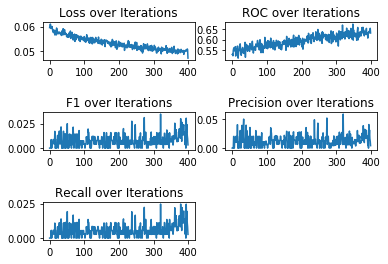

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(1)
ax_loss = fig.add_subplot(521)
ax_loss.set_title('Loss over Iterations')
ax_loss.plot(history_of_loss)

ax_roc = fig.add_subplot(522)
ax_roc.set_title('ROC over Iterations')
ax_roc.plot(np.array(history_of_roc)[:,1])

ax_roc = fig.add_subplot(525)
ax_roc.set_title('F1 over Iterations')
ax_roc.plot(np.array(history_of_f1)[:,1])

ax_roc = fig.add_subplot(526)
ax_roc.set_title('Precision over Iterations')
ax_roc.plot(np.array(history_of_precision)[:,1])

ax_roc = fig.add_subplot(529)
ax_roc.set_title('Recall over Iterations')
ax_roc.plot(np.array(history_of_recall)[:,1])

fig.canvas.draw()
plt.show()
# plt.savefig(fig_path + "bd_oh_5.png")

In [17]:
X_test, T_test = shuffleXY(X_val, T_val)
X_t = [construct_X(seqs_dicts[0], X_test, cutoff, n_gram_size, dimensions[0], 2000, 0),
       construct_X(seqs_dicts[1], X_test, cutoff, n_gram_size, dimensions[1], 2000, 0)]
T_t = np.array(T_test[0: 2000]).reshape(2000,cutoff,1)

In [26]:
x_t,y_t = random_sample_n_times(X_t, T_t, 1)
output = cnn_model.predict(x_t)

threshold = np.mean(output.ravel()) + 2 * np.std(output.ravel())
print ("Min value : ", np.min(output[0])," Max value : ",np.max(output[0]))

print ("Binding site index [probability]")
for i in range(cutoff):
    if y_t[0][i] == 1:
        print (i, output[0][i], output[0][i] > threshold)

        
print ("Output shape : ", output.shape)
print ("Positive predictions : ", np.sum((output.ravel() > threshold) * 1.0)) 
print ("Threshold : ", threshold)

Min value :  0.0013963  Max value :  0.00156251
Binding site index [probability]
32 [ 0.00146906] [False]
35 [ 0.00147865] [ True]
45 [ 0.00152271] [ True]
48 [ 0.00143862] [False]
Output shape :  (1, 706, 1)
Positive predictions :  38.0
Threshold :  0.00147268431829


In [27]:
print (y_t.ravel())
print((output.ravel() > threshold) * 1)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [21]:
# helper function to find the ranking of finger print points in prediction
#sequence_index: index of sequence to calculate F1
#label_set: set of labels, should be parallel with pred
#pred: 2d array with probabilities
#factor: factor for threshold for probabilities: factor*std+mean = threashold
def getF1(sequence_index, label_set, pred, factor):
    
    prob_mean = np.mean(pred[sequence_index])
    prob_std = np.std(pred[sequence_index]) 
    prob_th = prob_mean+factor*prob_std
    print (prob_th)
    cur_fp_ls = label_set[sequence_index]
    truePositive = 0
    falseNegative = 0
    falsePositive = 0
    for i in range(len(cur_fp_ls)):
        if(cur_fp_ls[i] == 1):
            if pred[sequence_index][i] >= prob_th:
                truePositive += 1
            else:
                falseNegative += 1
        else:
            if pred[sequence_index][i] >= prob_th and cur_fp_ls[i] == 0:
                falsePositive += 1
    
    Positive = 0
    Negative = 0
    for i in range(len(pred[sequence_index])):
        if pred[sequence_index][i] >= prob_th:
            Positive += 1
        else:
            Negative += 1
            
    precision = truePositive / (truePositive + falsePositive)
    recall = truePositive / (truePositive + falseNegative)
    F1 = 2 * (precision * recall) / (precision + recall)
    print ('Precision ', precision)
    print ('Recall ', recall)
    print ('F1 score ', F1)
    return truePositive, falseNegative, falsePositive, Positive, Negative

In [33]:
getF1(0, list(y_t.reshape(1,706)), list(output.reshape(1,706)), 3)

0.00150081107313
Precision  0.08333333333333333
Recall  0.25
F1 score  0.125


(1, 3, 11, 12, 694)

In [84]:
f1_score(list(y_t.ravel()), list(output.ravel() > threshold))

0.10126582278481014

In [65]:
list(output.reshape(1, 706))[0][67]

0.023962393